Pandas version: 2.2.3
NumPy version: 1.26.4
Python version: 3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]
Scikit-learn version: 1.5.2
Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)
Label distribution Training set:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Label distribution Test set:
label
normal             9711
neptune            4657
guess_p

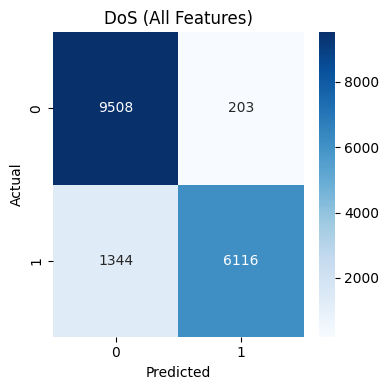

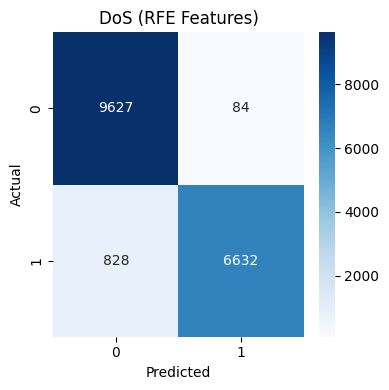

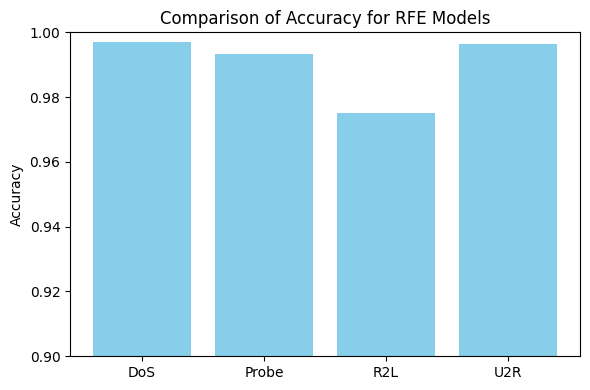

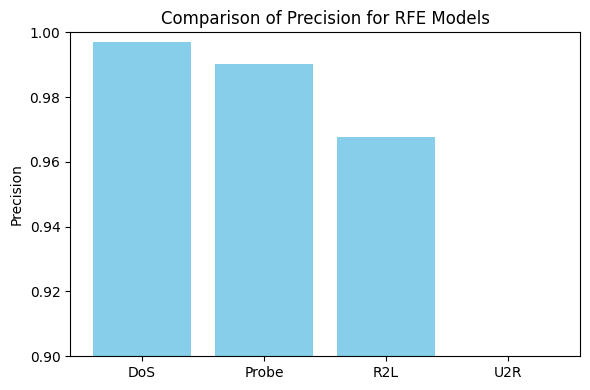

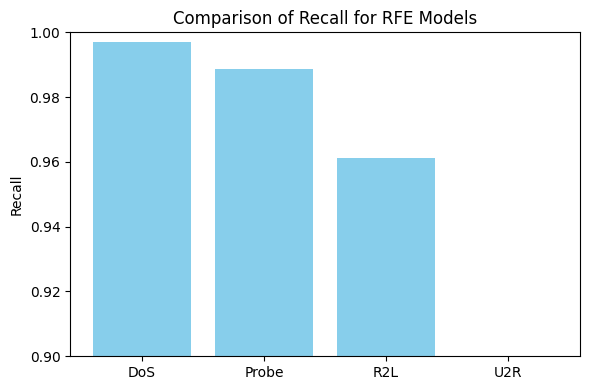

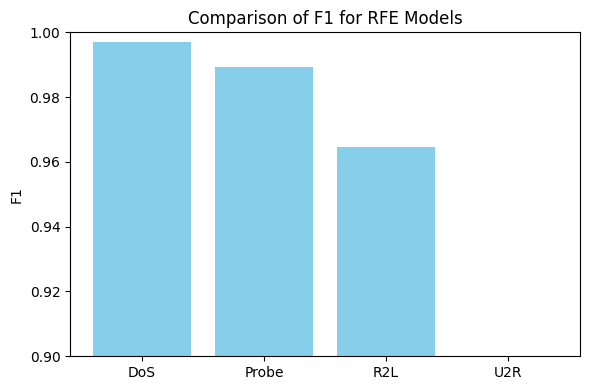

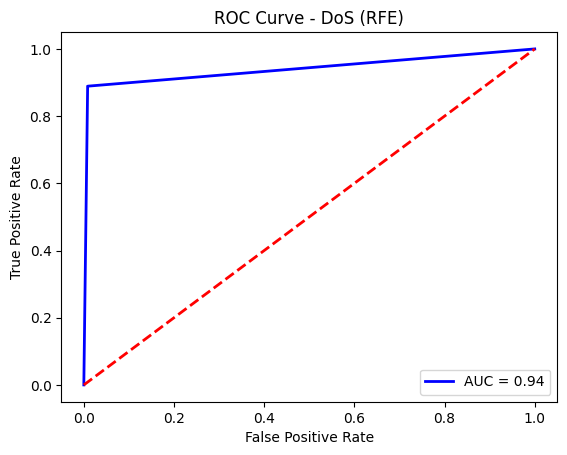

c:\Users\aakas\anaconda3\envs\DPgpu\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


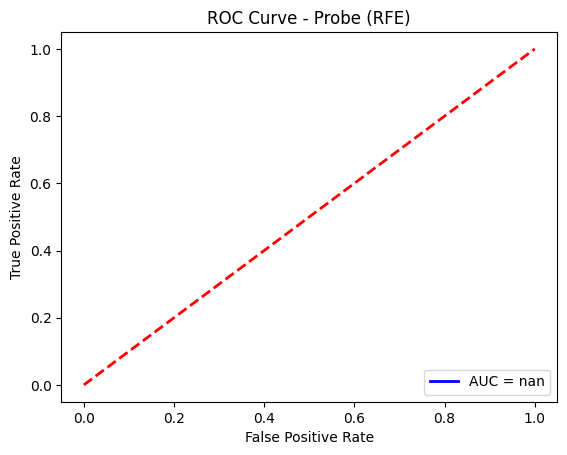

c:\Users\aakas\anaconda3\envs\DPgpu\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


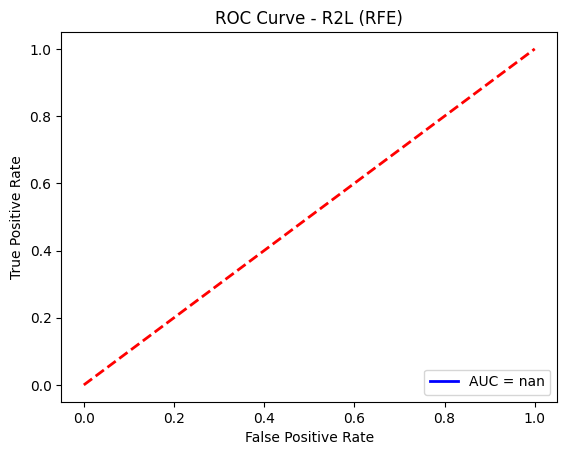

c:\Users\aakas\anaconda3\envs\DPgpu\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


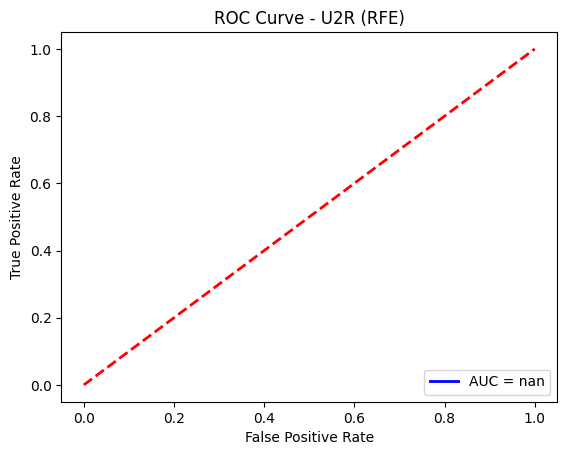

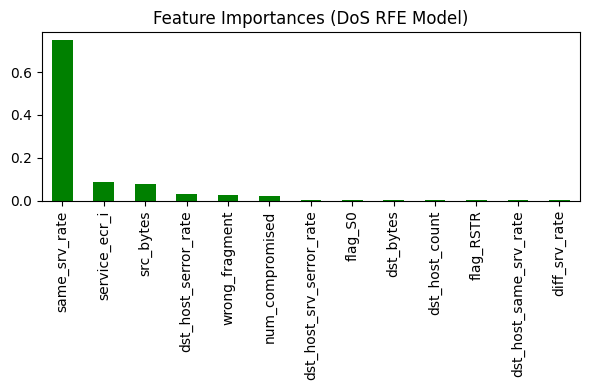

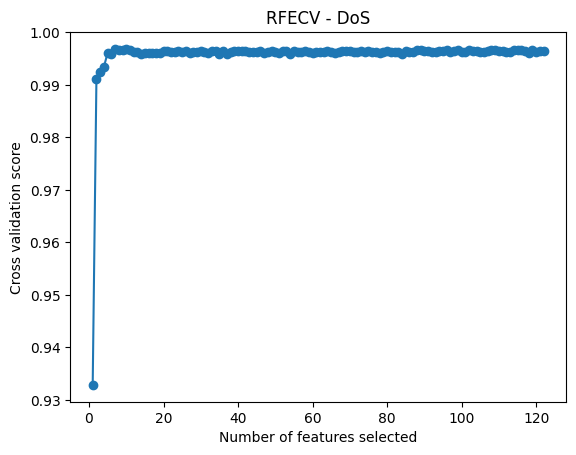

All processing and visualization complete.


In [1]:
import warnings
warnings.filterwarnings("ignore", message="Features .* are constant.")  # suppress the user warning about constant features

import pandas as pd
import numpy as np
import sys
import sklearn

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_classif, RFE, RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Python version:", sys.version)
print("Scikit-learn version:", sklearn.__version__)

col_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
    "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
    "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate",
    "srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]

df = pd.read_csv("KDDTrain+_2.csv", header=None, names=col_names)
df_test = pd.read_csv("KDDTest+_2.csv", header=None, names=col_names)

print('Dimensions of the Training set:', df.shape)
print('Dimensions of the Test set:', df_test.shape)
print("Label distribution Training set:")
print(df['label'].value_counts())
print("\nLabel distribution Test set:")
print(df_test['label'].value_counts())

categorical_columns = ['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]

unique_protocol = sorted(df.protocol_type.unique())
unique_service = sorted(df.service.unique())
unique_flag = sorted(df.flag.unique())

protocol_cols = ['Protocol_type_' + x for x in unique_protocol]
service_cols = ['service_' + x for x in unique_service]
flag_cols = ['flag_' + x for x in unique_flag]

dumcols = protocol_cols + service_cols + flag_cols

unique_service_test = sorted(df_test.service.unique())
test_service_cols = ['service_' + x for x in unique_service_test]
testdumcols = protocol_cols + test_service_cols + flag_cols

df_categorical_values_enc = df_categorical_values.apply(LabelEncoder().fit_transform)
testdf_categorical_values_enc = testdf_categorical_values.apply(LabelEncoder().fit_transform)

enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(), columns=dumcols)

testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(), columns=testdumcols)

# Align test with train
trainservice = df['service'].tolist()
testservice = df_test['service'].tolist()
difference = list(set(trainservice) - set(testservice))
difference = ['service_' + x for x in difference]
for col in difference:
    testdf_cat_data[col] = 0

newdf = df.join(df_cat_data)
newdf.drop(['flag','protocol_type','service'], axis=1, inplace=True)

newdf_test = df_test.join(testdf_cat_data)
newdf_test.drop(['flag','protocol_type','service'], axis=1, inplace=True)

# Use map instead of replace to avoid future downcasting warning
attack_mapping = {
    'normal':0, 'neptune':1, 'back':1, 'land':1, 'pod':1, 'smurf':1, 'teardrop':1,'mailbomb':1, 'apache2':1,
    'processtable':1, 'udpstorm':1, 'worm':1,
    'ipsweep':2, 'nmap':2, 'portsweep':2, 'satan':2, 'mscan':2, 'saint':2,
    'ftp_write':3,'guess_passwd':3,'imap':3,'multihop':3,'phf':3,'spy':3,'warezclient':3,'warezmaster':3,
    'sendmail':3,'named':3,'snmpgetattack':3,'snmpguess':3,'xlock':3,'xsnoop':3,'httptunnel':3,
    'buffer_overflow':4,'loadmodule':4,'perl':4,'rootkit':4,'ps':4,'sqlattack':4,'xterm':4
}

newdf['label'] = newdf['label'].map(attack_mapping)
newdf_test['label'] = newdf_test['label'].map(attack_mapping)

to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]

DoS_df = newdf[~newdf['label'].isin(to_drop_DoS)]
Probe_df = newdf[~newdf['label'].isin(to_drop_Probe)]
R2L_df = newdf[~newdf['label'].isin(to_drop_R2L)]
U2R_df = newdf[~newdf['label'].isin(to_drop_U2R)]

DoS_df_test = newdf_test[~newdf_test['label'].isin(to_drop_DoS)]
Probe_df_test = newdf_test[~newdf_test['label'].isin(to_drop_Probe)]
R2L_df_test = newdf_test[~newdf_test['label'].isin(to_drop_R2L)]
U2R_df_test = newdf_test[~newdf_test['label'].isin(to_drop_U2R)]

def scale_data(X_train, X_test):
    X_test = X_test[X_train.columns]  # ensure same columns/order
    scaler = preprocessing.StandardScaler().fit(X_train)
    return scaler.transform(X_train), scaler.transform(X_test)

X_DoS = DoS_df.drop('label', axis=1)
Y_DoS = DoS_df['label']
X_DoS_test = DoS_df_test.drop('label', axis=1)
Y_DoS_test = DoS_df_test['label']

X_DoS, X_DoS_test = scale_data(X_DoS, X_DoS_test)

X_Probe = Probe_df.drop('label', axis=1)
Y_Probe = Probe_df['label']
X_Probe_test = Probe_df_test.drop('label', axis=1)
Y_Probe_test = Probe_df_test['label']

X_Probe, X_Probe_test = scale_data(X_Probe, X_Probe_test)

X_R2L = R2L_df.drop('label', axis=1)
Y_R2L = R2L_df['label']
X_R2L_test = R2L_df_test.drop('label', axis=1)
Y_R2L_test = R2L_df_test['label']

X_R2L, X_R2L_test = scale_data(X_R2L, X_R2L_test)

X_U2R = U2R_df.drop('label', axis=1)
Y_U2R = U2R_df['label']
X_U2R_test = U2R_df_test.drop('label', axis=1)
Y_U2R_test = U2R_df_test['label']

X_U2R, X_U2R_test = scale_data(X_U2R, X_U2R_test)

colNames = list(DoS_df.drop('label', axis=1))

# (Optional) Drop constant features before feature selection if desired:
# X_DoS = X_DoS[:, X_DoS.var(axis=0) != 0]
# Same for others if necessary.

selector = SelectPercentile(f_classif, percentile=10)
np.seterr(divide='ignore', invalid='ignore')
X_newDoS = selector.fit_transform(X_DoS, Y_DoS)

clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=13)
rfe.fit(X_DoS, Y_DoS)
X_rfeDoS = rfe.transform(X_DoS)
rfecolindex_DoS = [i for i,x in enumerate(rfe.support_) if x]

rfe.fit(X_Probe, Y_Probe)
X_rfeProbe = rfe.transform(X_Probe)
rfecolindex_Probe = [i for i,x in enumerate(rfe.support_) if x]

rfe.fit(X_R2L, Y_R2L)
X_rfeR2L = rfe.transform(X_R2L)
rfecolindex_R2L = [i for i,x in enumerate(rfe.support_) if x]

rfe.fit(X_U2R, Y_U2R)
X_rfeU2R = rfe.transform(X_U2R)
rfecolindex_U2R = [i for i,x in enumerate(rfe.support_) if x]

X_DoS_test2 = X_DoS_test[:, rfecolindex_DoS]
X_Probe_test2 = X_Probe_test[:, rfecolindex_Probe]
X_R2L_test2 = X_R2L_test[:, rfecolindex_R2L]
X_U2R_test2 = X_U2R_test[:, rfecolindex_U2R]

clf_DoS = DecisionTreeClassifier(random_state=0).fit(X_DoS, Y_DoS)
clf_Probe = DecisionTreeClassifier(random_state=0).fit(X_Probe, Y_Probe)
clf_R2L = DecisionTreeClassifier(random_state=0).fit(X_R2L, Y_R2L)
clf_U2R = DecisionTreeClassifier(random_state=0).fit(X_U2R, Y_U2R)

clf_rfeDoS = DecisionTreeClassifier(random_state=0).fit(X_rfeDoS, Y_DoS)
clf_rfeProbe = DecisionTreeClassifier(random_state=0).fit(X_rfeProbe, Y_Probe)
clf_rfeR2L = DecisionTreeClassifier(random_state=0).fit(X_rfeR2L, Y_R2L)
clf_rfeU2R = DecisionTreeClassifier(random_state=0).fit(X_rfeU2R, Y_U2R)

def plot_conf_matrix(model, X, Y, title):
    Y_pred = model.predict(X)
    cm = confusion_matrix(Y, Y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_conf_matrix(clf_DoS, X_DoS_test, Y_DoS_test, "DoS (All Features)")
plot_conf_matrix(clf_rfeDoS, X_DoS_test2, Y_DoS_test, "DoS (RFE Features)")

def evaluate_metrics(model, X, Y):
    accuracy = cross_val_score(model, X, Y, cv=10, scoring='accuracy').mean()
    precision = cross_val_score(model, X, Y, cv=10, scoring='precision_macro').mean()
    recall = cross_val_score(model, X, Y, cv=10, scoring='recall_macro').mean()
    f1 = cross_val_score(model, X, Y, cv=10, scoring='f1_macro').mean()
    return accuracy, precision, recall, f1

DoS_scores = evaluate_metrics(clf_rfeDoS, X_DoS_test2, Y_DoS_test)
Probe_scores = evaluate_metrics(clf_rfeProbe, X_Probe_test2, Y_Probe_test)
R2L_scores = evaluate_metrics(clf_rfeR2L, X_R2L_test2, Y_R2L_test)
U2R_scores = evaluate_metrics(clf_rfeU2R, X_U2R_test2, Y_U2R_test)

categories = ['DoS','Probe','R2L','U2R']
metrics = ['Accuracy','Precision','Recall','F1']
all_scores = np.array([DoS_scores, Probe_scores, R2L_scores, U2R_scores])

for i, metric in enumerate(metrics):
    plt.figure(figsize=(6,4))
    plt.bar(categories, all_scores[:,i], color='skyblue')
    plt.title(f"Comparison of {metric} for RFE Models")
    plt.ylabel(metric)
    plt.ylim([0.9,1.0])  # adjust as needed
    plt.tight_layout()
    plt.show()

def plot_roc(model, X, Y, title):
    # Ensure binary classification. If there's only one class, this might fail.
    # Check if Y contains both classes (0 and 1). If not, you get AUC = nan.
    if len(np.unique(Y)) < 2:
        print(f"Cannot plot ROC for {title}: only one class present in Y.")
        return
    Y_score = model.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(Y, Y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + title)
    plt.legend(loc='lower right')
    plt.show()

plot_roc(clf_rfeDoS, X_DoS_test2, Y_DoS_test, "DoS (RFE)")
plot_roc(clf_rfeProbe, X_Probe_test2, Y_Probe_test, "Probe (RFE)")
plot_roc(clf_rfeR2L, X_R2L_test2, Y_R2L_test, "R2L (RFE)")
plot_roc(clf_rfeU2R, X_U2R_test2, Y_U2R_test, "U2R (RFE)")

importances = clf_rfeDoS.feature_importances_
selected_features = [colNames[i] for i in rfecolindex_DoS]
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
feat_imp.plot(kind='bar', color='green')
plt.title("Feature Importances (DoS RFE Model)")
plt.tight_layout()
plt.show()

rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)
mean_scores = rfecv_DoS.cv_results_['mean_test_score']
plt.figure()
plt.plot(range(1, len(mean_scores)+1), mean_scores, marker='o')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.title("RFECV - DoS")
plt.show()

print("All processing and visualization complete.")
